# Assignment 2 specification

The purpose of this assignment is to analyse the Bike Sharing Dataset hosted on the UCI repository of datasets.

The dataset is provided with this notebook as a zip file.

There are two related datasets in the zip file: one aggregated by day, and the other aggregated by hour.

They represent the number of bikes that were shared/hired in Washington over that time period, together with the factors that are believed to predict the demand for such bikes.

They include the time unit and various measures of the weather etc. (in terms of temperature, humidity and wind-speed). More description can be found [here](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset).

You are asked to

1. Read the _hourly_ data and split into training and test data __[5 marks]__
2. For the _training data_ only, use exploratory data analysis to learn about the data and to indicate how to build a model __[15 marks]__
3. Using a forward selection approach, build a regression model that offers the best performance, using a machine learning measure (i.e., prediction accuracy on the test data) __[30 marks]__
   - You need to pay particular attention to the regression model assumptions
   - For best performance, you will also need to perform feature engineering
     - modifying the existing features
     - transforming them
     - merging them
     - keeping feature correlation as low as possible
   - 10-fold cross-validation should be used to estimate the uncertainty in the fitted model parameters.
4. Identify the 3 target columns. Which of these target columns is easiest to predict accurately? __[5 marks]__
5. Using this "preferred target", derive a new target whose values are the grouped label (taking the values `Q1`, `Q2`, `Q3`, `Q4`) for demand in the quartiles (0 < demand <= 25th percentile of demand), (25th percentile of demand < demand <= 50th percentile of demand), .. You might find the [pandas quantile calculator](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.quantile.html) convenient when computing the quartile end points (25th, 50th and 75th percentiles), and pandas filtering by rows  convenient for assigning the new labels. __[5 marks]__
6. Use _two_ classification procedures to predict these demand quartiles, repeating the forward selection procedure to find the best model for each, but this time focusing on classification accuracy on the test set as the measure of performance. Are the same features used in each of the two models? __[35 marks]__
7. Which of the two machine learning procedures (regression and classification) provides the highest classification accuracy on the test set? Why is this? __[5 marks]__

In [121]:
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport #https://pypi.org/project/pandas-profiling/
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import linear_model
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import figure
import seaborn as sns
import ipywidgets as widgets
import pingouin as pg
import phik as phik

sns.set_theme(palette="pastel")
sns.set_style("darkgrid", {'grid.color' : '#adadad' }) 

# Task 1: Read the _hourly_ data and split into training and test data.

##Start of Answer 1##

In [129]:
# read in the hourly data from CSV
hourDF = pd.read_csv('data/hour.csv') 
# rename columns to be more human legible
hourDF = hourDF.rename(columns={'instant': 'index', 'dteday': 'date', 'yr': 'year', 'mnth': 'month', 'hr': 'hour', 'weathersit': 'weather', 'temp': 'temperature', 'atemp': 'temperature-feels-like', 'hum': 'humidity','windspeed': 'wind_speed' ,'casual': 'casual_users', 'registered': 'registered_users', 'cnt': 'total_users'})
hourDF[['season', 'holiday', 'year','weekday', 'workingday', 'weather', 'month', 'hour', 'date']] = hourDF[['season', 'holiday', 'year','weekday', 'workingday', 'weather', 'month', 'hour', 'date']].apply(lambda x: x.astype('category'))
hourDF.to_pickle('data/hourFormatted.pk1')
# hourDF.to_csv('data/hourFormatted.csv', index = False)
hourDF = pd.read_pickle('data/hourFormatted.pk1')
hourDF = hourDF.drop(columns={'date','index'})

#Split the Dataframe into test, training and validation data.
# https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/
targets = hourDF[['casual_users','registered_users','total_users']]
features = hourDF.drop(columns={'casual_users','registered_users','total_users'})

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2)
print(f'Training Data before validation split:\n\nX Training data: \n{X_train.shape, X_test.shape}\n\ny Training Data: \n {y_train.shape, y_test.shape}\n')
X_train, X_validation = train_test_split(X_train, test_size=0.1)
y_train, y_validation = train_test_split(y_train, test_size=0.1)
print(f'Training Data after validation split:\n\nX Training data: \n{X_train.shape, X_test.shape}\n\ny Training Data: \n {y_train.shape, y_test.shape}\n')
print(f'X Validation data: \n{X_validation.shape}\n\ny Validation Data: \n {y_validation.shape}')
#X for features
#y for targets

# target -> what you're looking to predict -> casual_users, registered_users, total_users
# features is literally the rest

Training Data before validation split:

X Training data: 
((13903, 12), (3476, 12))

y Training Data: 
 ((13903, 3), (3476, 3))

Training Data after validation split:

X Training data: 
((12512, 12), (3476, 12))

y Training Data: 
 ((12512, 3), (3476, 3))

X Validation data: 
(1391, 12)

y Validation Data: 
 (1391, 3)


In this task and the in the above cell I'm reading in the hour data from the csv file and renaming columns for it to be more human legible. </br>
I'm also changing the data types of certain columns to be categorical rather than 'object' so that it can be plotted in EDA as part of task 2.
The dataset is also being pickled and being read from the pickle in order to have a new dataset file that differs from the original dataset, rather than overwriting the dataset. Pickling maintains the data types across reads so that the column name conversion does not need to occur a second time. </br></br>
I'm also creating x and y training data split & x and y test splits. This will also be used later.
I'm then printing out the shapes of the split data so that I know the split worked successfully. Seeing as there's 3 targets then the y training and test should only have 3 columns, which it does in my case.
For overall context X represents features, y represents targets.

In [76]:
print(f'Features:\n {features.head(5)}\n')
print(f'\nTargets:\n {targets.head(5)}\n')
print(f'{hourDF.info()}\n')
print(hourDF.isna().sum())

Features:
   season year month hour holiday weekday workingday weather  temperature  \
0      1    0     1    0       0       6          0       1         0.24   
1      1    0     1    1       0       6          0       1         0.22   
2      1    0     1    2       0       6          0       1         0.22   
3      1    0     1    3       0       6          0       1         0.24   
4      1    0     1    4       0       6          0       1         0.24   

   temperature-feels-like  humidity  wind_speed  
0                  0.2879      0.81         0.0  
1                  0.2727      0.80         0.0  
2                  0.2727      0.80         0.0  
3                  0.2879      0.75         0.0  
4                  0.2879      0.75         0.0  


Targets:
    casual_users  registered_users  total_users
0             3                13           16
1             8                32           40
2             5                27           32
3             3                1

In the above code cell, I'm checking the head of the features and targets to see if they have any values still assigned, which they are.</br>
I'm also checking the info of the original dataframe to see if the data types and names of the columns if it's all right. </br>
Additionally, I'm checking if there's any null or NAs present in the dataframe, which there isn't.

##End of Answer 1##

# Task 2: For the training data only, use exploratory data analysis to learn about the data and to indicate how to build a model

##Start of Answer 2##

In [124]:
trainingDF = X_train.join(y_train) #https://www.kdnuggets.com/2023/03/3-ways-merge-pandas-dataframes.html
trainingDF, validation = train_test_split(trainingDF, test_size=0.1)
# trainingDF.to_csv('data/trainingDF.csv', index= False)
profile = ProfileReport(trainingDF, title="Pandas Profiling Report - Training data")
trainingDF.profile_report()


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In the above cell I'm using ydata_profiling from ProfileReport module to Exploratory Data Analysis. The use of of the module saves some time and ambiguity from doing the EDA myself. The code above plots the columns and produces assumptions such as whether columns are correlated or imbalanced. The code also displays how data is distributed and if a columns had a significant number of zeros. I will also be plotting some graphs and a heatmap myself in order to double check against to profile to see if the profiling is accurate.

From this I can see the following data:
- temperature is highly overall correlated with temperature-feels-like and 2 other fields - High correlation
- temperature-feels-like is highly overall correlated with temperature and 2 other fields - High correlation
- casual_users is highly overall correlated with temperature and 3 other fields - High correlation
- registered_users is highly overall correlated with casual_users and 1 other fields - High correlation
- total_users is highly overall correlated with casual_users and 1 other fields - High correlation
- season is highly overall correlated with temperature and 2 other fields - High correlation
- month is highly overall correlated with season - High correlation
- weekday is highly overall correlated with workingday - High correlation
- workingday is highly overall correlated with weekday - High correlation
- holiday is highly imbalanced (81.2%) - Imbalance
- hour is uniformly distributed
- wind_speed has 1753 (12.6%) zeros
- casual_users has 1264 (9.1%) zeros
</br></br>
Note: holiday is unbalanced due to the fact that theres a significant less amount of holiday days compared to non-holiday days. </br>
I will be checking these correlations later when I create a correlation matrix and heatmap. 

#### Providing Context for columns -> Legend
##### Season:
- 1 represents 'Spring'
- 2 represents 'Summer'
- 3 represents 'Fall/Autumn'
- 4 represents 'Winter'

##### Year:
- 0 represents '2011'
- 1 represents '2012'

##### Month:
- 1 - 12 represents 'January - December'

##### Hour:
- 0 - 23 represents '12AM - 11PM'

##### Holiday:
- 0 represents a non-holiday
- 1 represents a holiday

##### Weekday:
- 0 represents 'Sunday'
- 1 represents 'Monday'
- 2 represents 'Tuesday'
- 3 represents 'Wednesday'
- 4 represents 'Thursday'
- 5 represents 'Friday'
- 6 represents 'Saturday'

##### Working_day:
- 1 represents whether people are working that day (not weekend or holiday)
- 0 represents whether people are **NOT** working that day (weekend or holiday)

##### Weather:
- 1 represents Mild weather (Clear, Few clouds, Partly cloudy, Partly cloudy)
- 2 represents Misty weather (Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist)
- 3 represents Light Wet weather (Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds)
- 4 represents Heavy Wet weather (Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog)

##### Temperature:
- Normalized temperature in Celsius -> Values are divided to 41 -> -8 degrees is min value (0.0 represents -8 degrees)

##### Temperature-feels-like:
- Normalized the feels-like temperature -> values are divided to 50 -> minimum value is -16, max value is +50 (before division)

##### Humidity
- Normalized humidity -> decimal point represents percentage, i.e. 0.1 = 10%

##### Wind_speed
- Normalized wind speed. The values are divided to 67 (max)

##### Casual_users:
- Count of casual users

##### Registered_users:
- Count of registered users

##### Total_users:
- Count of total rental bikes including both casual and registered

In [112]:
def columnDescribe(column_name):
    describe = trainingDF[column_name].describe()
    print(f'\n\n{describe}')

def columnCountAndPercentage(column_name):
    percentage = trainingDF[column_name].value_counts(normalize=True)
    values = trainingDF[column_name].value_counts()
    table = pd.concat([percentage, values], axis=1, keys=['percentage', 'count'])
    print(f'\n\n{table}')

def createHeatmap(correlation):
    heatmap = sns.heatmap(correlation, annot=True, square=True, fmt=".1f", linewidths=0.1, linecolor="black", vmin=1, vmax=-1)

In [111]:
for col in trainingDF:
    columnDescribe(col)

for col in trainingDF:
    columnCountAndPercentage(col)



count     13903
unique        4
top           3
freq       3629
Name: season, dtype: int64


count     13903
unique        2
top           1
freq       6959
Name: year, dtype: int64


count     13903
unique       12
top           8
freq       1202
Name: month, dtype: int64


count     13903
unique       24
top          21
freq        594
Name: hour, dtype: int64


count     13903
unique        2
top           0
freq      13503
Name: holiday, dtype: int64


count     13903
unique        7
top           6
freq       1999
Name: weekday, dtype: int64


count     13903
unique        2
top           1
freq       9512
Name: workingday, dtype: int64


count     13903
unique        4
top           1
freq       9184
Name: weather, dtype: int64


count    13903.000000
mean         0.497540
std          0.192474
min          0.020000
25%          0.340000
50%          0.500000
75%          0.660000
max          1.000000
Name: temperature, dtype: float64


count    13903.000000
mean         0.476

Using the profile and .describe() for each columns I can see the following information regarding numerical values:
##### Temperature:
- mean:&nbsp;&nbsp;&nbsp;&nbsp;         0.497540
- std:&nbsp;&nbsp;&nbsp;&nbsp;         0.192474
- min:&nbsp;&nbsp;&nbsp;&nbsp;          0.020000
- 25%:&nbsp;&nbsp;&nbsp;&nbsp;          0.340000
- 50%:&nbsp;&nbsp;&nbsp;&nbsp;          0.500000
- 75%:&nbsp;&nbsp;&nbsp;&nbsp;          0.660000
- max:&nbsp;&nbsp;&nbsp;&nbsp;          1.000000

##### Temperature-feels-like:
- mean:&nbsp;&nbsp;&nbsp;&nbsp;         0.476289
- std:&nbsp;&nbsp;&nbsp;&nbsp;         0.171860
- min:&nbsp;&nbsp;&nbsp;&nbsp;          0.000000
- 25%:&nbsp;&nbsp;&nbsp;&nbsp;          0.333300
- 50%:&nbsp;&nbsp;&nbsp;&nbsp;          0.484800
- 75%:&nbsp;&nbsp;&nbsp;&nbsp;          0.621200
- max:&nbsp;&nbsp;&nbsp;&nbsp;          1.000000

##### Humidity:
- mean:&nbsp;&nbsp;&nbsp;&nbsp;         0.627253
- std:&nbsp;&nbsp;&nbsp;&nbsp;          0.193224
- min:&nbsp;&nbsp;&nbsp;&nbsp;          0.000000
- 25%:&nbsp;&nbsp;&nbsp;&nbsp;          0.475000
- 50%:&nbsp;&nbsp;&nbsp;&nbsp;          0.630000
- 75%:&nbsp;&nbsp;&nbsp;&nbsp;          0.780000
- max:&nbsp;&nbsp;&nbsp;&nbsp;          1.000000

##### Wind_speed:
- mean:&nbsp;&nbsp;&nbsp;&nbsp;         0.189620
- std:&nbsp;&nbsp;&nbsp;&nbsp;          0.122317
- min:&nbsp;&nbsp;&nbsp;&nbsp;          0.000000
- 25%:&nbsp;&nbsp;&nbsp;&nbsp;          0.104500
- 50%:&nbsp;&nbsp;&nbsp;&nbsp;          0.194000
- 75%:&nbsp;&nbsp;&nbsp;&nbsp;          0.253700
- max:&nbsp;&nbsp;&nbsp;&nbsp;          0.850700

##### Casual_users:
- mean:&nbsp;&nbsp;&nbsp;&nbsp;        35.762138
- std:&nbsp;&nbsp;&nbsp;&nbsp;         49.433153
- min:&nbsp;&nbsp;&nbsp;&nbsp;          0.000000
- 25%:&nbsp;&nbsp;&nbsp;&nbsp;          4.000000
- 50%:&nbsp;&nbsp;&nbsp;&nbsp;         17.000000
- 75%:&nbsp;&nbsp;&nbsp;&nbsp;         48.000000
- max:&nbsp;&nbsp;&nbsp;&nbsp;        367.000000

##### Registered_users:
- mean:&nbsp;&nbsp;&nbsp;&nbsp;        154.596993
- std:&nbsp;&nbsp;&nbsp;&nbsp;         152.311722
- min:&nbsp;&nbsp;&nbsp;&nbsp;           0.000000
- 25%:&nbsp;&nbsp;&nbsp;&nbsp;          34.000000
- 50%:&nbsp;&nbsp;&nbsp;&nbsp;         116.000000
- 75%:&nbsp;&nbsp;&nbsp;&nbsp;         221.000000
- max:&nbsp;&nbsp;&nbsp;&nbsp;         886.000000

##### Total_users:
- mean:&nbsp;&nbsp;&nbsp;&nbsp;        190.359131
- std:&nbsp;&nbsp;&nbsp;&nbsp;         182.361218
- min:&nbsp;&nbsp;&nbsp;&nbsp;           1.000000
- 25%:&nbsp;&nbsp;&nbsp;&nbsp;          40.000000
- 50%:&nbsp;&nbsp;&nbsp;&nbsp;         142.000000
- 75%:&nbsp;&nbsp;&nbsp;&nbsp;         282.000000
- max:&nbsp;&nbsp;&nbsp;&nbsp;         977.000000



In [119]:
cat_col = [col for col in trainingDF if trainingDF[col].dtype == 'category']
num_col = [col for col in trainingDF if trainingDF[col].dtype != 'category']
cat_feature_col = [col for col in X_train if X_train[col].dtype == 'category']
cat_feature_num = [col for col in X_train if X_train[col].dtype != 'category']
target_col = [col for col in y_train if y_train[col].dtype]

dropdownCat= widgets.Dropdown(options=cat_col, value=cat_col[0], description="Category")
dropdownNum = widgets.Dropdown(options=num_col, value=num_col[0], description="Numerical")

dropdownCatFeatures= widgets.Dropdown(options=cat_feature_col, value=cat_feature_col[0], description="Category")
dropdownNumFeatures = widgets.Dropdown(options=cat_feature_num, value=cat_feature_num[0], description="Numerical")
dropdownTarget = widgets.Dropdown(options=target_col, value=target_col[0], description="Targets")

orientation = ["h", "v"]
dropdownOrientation = widgets.Dropdown(options=orientation, value=orientation[0], description="Orientation")

uiControlsNum = widgets.HBox([dropdownNum])
uiControlsCat = widgets.HBox([dropdownCat])
uiControlsNumFeatures = widgets.HBox([dropdownNumFeatures, dropdownTarget])
uiControlsCatFeatures = widgets.HBox([dropdownCatFeatures, dropdownTarget])
# uiControlsTargets = widgets.HBox([dropdownTarget])

def doHistPlotNum(column):
    histPlotNum=sns.histplot(data=trainingDF, x=column, bins=40, color='red')

def doHistplotCat(column):
    histplotcat=sns.histplot(data=trainingDF, x=column, color='green')

def doLMplot(columnX, columnY):
    lmplot=sns.lmplot(data=trainingDF, x=columnX, y=columnY, line_kws={'color': 'gray'})

def doCatPlot(columnX, columnY):
    catplot=sns.catplot(data=trainingDF, x=columnX, y=columnY, orient='h', kind='bar')

def doCrosstab(column_1, column_2):
    crosstab = pd.crosstab(column_1, column_2)
    print(crosstab)


In [51]:
out = widgets.interactive_output(doHistPlotNum, {"column":dropdownNum})
display(uiControlsNum, out)

Output()

Viewing the .describe() and plots for numerical values I can make note of the following points and assumptions:

**Temperature**
- The mean value for temperature is 0.4975 and the median value is 0.5, max is 1 and min is 0.02.
- The mean and median value being close to each other means the data is well distributed.
- Looking at the graph, I can see that bike usage decreases as the temperature reaches the extremes i.e. too cold or too hot. That makes sense seeing as people wouldn't be out for very long in the extremes.

**Temperature-feels-like**
- The mean value for temperature is 0.476289 and the median value is 0.484800, max is 1 and min is 0.00.
- The mean and median value being close to each other means the data is well distributed.
- Looking at the graph, I can see that it's relatively similar to temperature. Majority of people use the bikes when it doesn't "feel" too cold or too hot out.

**Humidity**
- The mean value for humidity is 0.627253 and the median value is 0.630000, max is 1 and min is 0.00.
- The mean and median value being close to each other means the data is well distributed.
- Looking at the graph I can see that humidity is more concentrated towards 0.6 and has a humidity leaning towards 1.0. This means that when that when humidity decrease then usages decreases (usually humidity ties in with temperature). There's still a substantial number of users when the humidity approaches 1.0.

**Wind_speed**
- The mean value for wind_speed is 0.189620 and the median value is 0.194000, max is 0.850700 and min is 0.00.
- The mean and median value being close to each other means the data is well distributed.
- Looking at the graph I can see that a lot more users are present when the wind speed is lower and the distribution leans more towards 0.0 rather than 1.0. This makes sense seeing as people wouldn't ride bikes when it's really windy.

**Casual_users**
- The mean value for casual users is 35.762138 and the median value is 17.000000, max is 367.000000 and min is 0.00.
- The mean and median value not being close to each other means the data is not well distributed.
- Looking at graph I can see that hourly, there's a lot of low numbers for casual users and it heavily leans towards single digits and lower value double digits. This could be because there's a lot lower amount of people riding casually compared to registered users.

**Registered_users**
- The mean value for registered users is 154.596993 and the median value is 116.000000, max is 886.000000 and min is 0.00.
- The mean and median value not being close to each other means the data is not well distributed.
- Viewing the graph I can see that hourly, there's a lot of low numbers of registered users, but not as much as casual users. There seems to be more registered users than casual users, which could be for the fact that there may be more reoccurring users where they register and might have to pay less when renting a bike because they registered.

**Total_users**
- A combination of registered and casual users.
- The mean value for total users is 190.359131 and the median value is 142.000000, max is 977.000000 and min is 1.000000.
- The mean and median value not being close to each other means the data is not well distributed.
- Viewing the graph I can see that the users are more evenly distributed but there's still a large amount of lower amount of users. Similar to what was viewed in registered and casual users.

In [52]:
out = widgets.interactive_output(doHistplotCat, {"column":dropdownCat})
display(uiControlsCat, out)

Output()

Viewing the value count and plots for categorical values I can make note of the following points and assumptions:</br>
**Season**
- User count hourly is relatively equal across seasons. There is of course slight variation between each one but they're still quite even.
- I'm not sure as to why that is because I would assume that colder seasons may have less users, which is slightly true but not by a substantial margin. This may be the case the country is relatively mild all year round which allows for cycling in all seasons.

**Year**
- User count for bikes are almost equal across both years.
- There are slightly more in "1" than in "0". Maybe not a lot of people have started to take up biking, hence the miniscule increase.

**Month**
- User count is still relatively across the months but there is a slightly bigger difference between the months, where the first few months of the year have a slightly lower user count whereas the middle (summer months) have more users due to weather.
- More people seem to cycle when the weather is better. In this case it would be in the middle of year. This would also maybe account for non-locals renting bikes since people usually take their holidays in the summer.

**Hour**
- Surprisingly, user count does not differ too much when it comes to renting. While the early hours have a lesser amount of people renting, there's still a fairly even amount of users.
- I do not know why this is, because to me I'd think that the AM would have a very few number of users.

**Holiday**
- User count has a very significant difference between a holiday and non-holiday.
- This makes sense in the fact that majority of the days of the year are not holidays, so there will be a skew in renting bikes since there are so few holidays.

**Weekday**
- Again, user count seems to be relatively even across the days of the week.
- I would think that there may be a skew due to people not renting bikes for work or school on a weekend but it doesn't seem to be the case.

**Workingday**
- There is a skew in user count when it comes to working day and the graph leans towards working days, which makes sense in the fact that there are more working days in the week compared to weekend days.

**Weather**
- There is a variation of user counts depending on the weather.
- This skew could be due to factors like: The country does not experience a certain weather type very often and of course people not renting bikes in bad weather.
- In the context of the graph, a lot more people ride bikes when the weather is more mild and isn't wet. Which to me makes sense because I wouldn't want to ride a bike in the rain unless I had to but this could also go back to argument where weather types (like rain or snow) may be less common due to geographical location.  

In [69]:
out = widgets.interactive_output(doLMplot, {"columnX":dropdownNumFeatures, "columnY":dropdownTarget})
display(uiControlsNumFeatures, out)

Output()

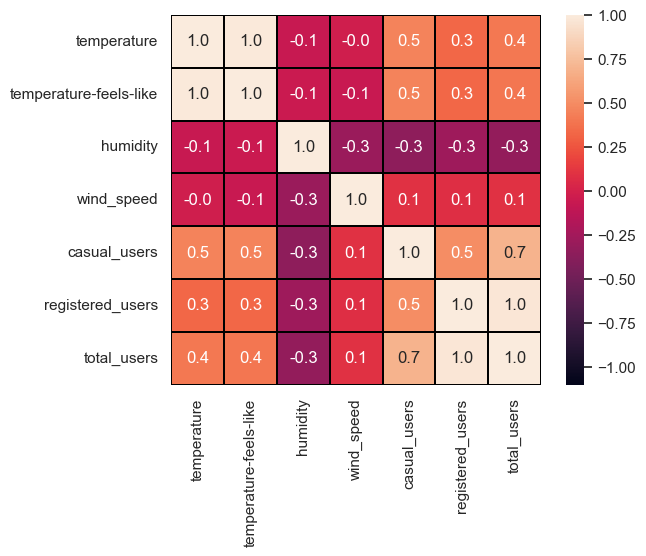

In [117]:
numericalHourDF = X_train[['temperature','temperature-feels-like','humidity','wind_speed']]
numericalHourDF = numericalHourDF.join(y_train)
corr = numericalHourDF.corr()
createHeatmap(corr)

In the above 2 cells, I have graphed numerical values against the targets and I have also created a heatmap with the numerical values and targets.</br>
From the heatmap I can see that there is a strong correlation between the following:</br>
- Casual Users and Total users (0.7). This makes sense seeing as total_users contains casual_users.
- Registered users and Total users (1.0). This makes sense seeing as total_users contains registered users too.
- Temperature and Temperature-feels-like (0.5) with casual users.
- Temperature and Temperature-feels-like (1.0). This makes sense seeing as they wouldn't differ from each other all that much between temperatures.
</br></br>

From the graphs I can see the following: </br>
- As the temperature increase, so to does the number of casual users. It increases as it approaches 0.7 but then starts to decrease since it starts getting "too hot". The same is true for temperature-feels-like.

In [74]:
out = widgets.interactive_output(doCatPlot, {"columnX":dropdownTarget, "columnY":dropdownCatFeatures})
display(uiControlsCatFeatures, out)

Output()

interval columns not set, guessing: ['casual_users', 'registered_users', 'total_users']


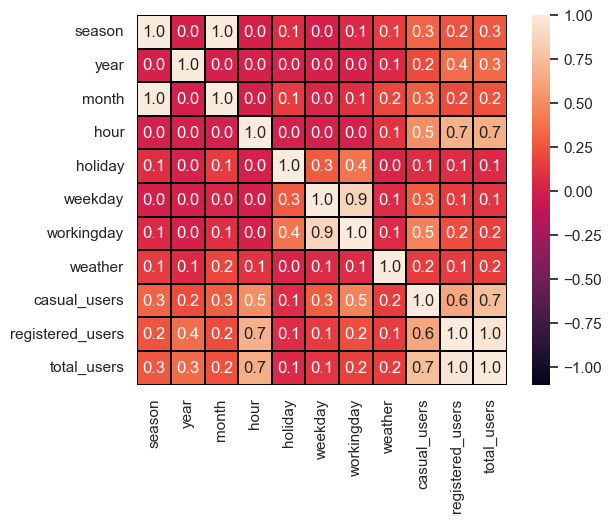

In [118]:
categoricalHourDF = X_train.drop(columns={'temperature','temperature-feels-like','humidity','wind_speed'})
categoricalHourDF = categoricalHourDF.join(y_train)
correlationCategoricalTargets = categoricalHourDF.phik_matrix()
createHeatmap(correlationCategoricalTargets)

In the above 3 cells, I have graphed categorical values against the targets and created a heatmap with the categorical values and targets.</br>
From the heatmap I can see the following strong correlations:
- Season and Month have a direct correlation (1.0). This makes sense seeing certain weather is way more common depending on the month.
- Registered(0.7), Total(0.7) and Casual Users(0.5) with hour has a correlation.
- Weekday and workingday has a very strong correlation (0.9) </br>

In [120]:
doCrosstab(X_train['month'], X_train['season'])

season     1     2     3     4
month                         
1       1121     0     0     0
2       1084     0     0     0
3        748   398     0     0
4          0  1133     0     0
5          0  1196     0     0
6          0   762   390     0
7          0     0  1187     0
8          0     0  1202     0
9          0     0   850   306
10         0     0     0  1168
11         0     0     0  1170
12       425     0     0   763


In [121]:
doCrosstab(X_train['workingday'], X_train['weekday'])

weekday        0     1     2     3     4     5     6
workingday                                          
0           1992   292    20    15    38    35  1999
1              0  1680  1949  1968  1955  1960     0


I have created crosstabs in order to analyse the categorical - categorical correlations.</br>
Viewing the crosstabs I can see: 
- Month 1-3 is commonly considered Spring, Month 3-6 is referred to as Summer, Month 6-9 is considered Autumn and 9-12 is considered Winter. This makes a lot of sense since season is 100% dependant on month.
- Throughout the weekdays that day 1(Monday) to day 5(Friday) is considered a non-weekend day whereas Sunday and Saturday are not working days. 

From the graphs I can see the following information regarding correlations between categorical features and targets:
- Hour of the day influences when total, casual and registered users rent a bike. On the graph I can see that for total users, the most common hours of the day to rent is: 8am, 5pm and 6pm. This makes sense when the most common work times are from 9am to 5pm. This is also the same for registered users and hour. Alternatively, the hour for casual users is between 12PM and 6PM.

interval columns not set, guessing: ['temperature', 'temperature-feels-like', 'humidity', 'wind_speed', 'casual_users', 'registered_users', 'total_users']


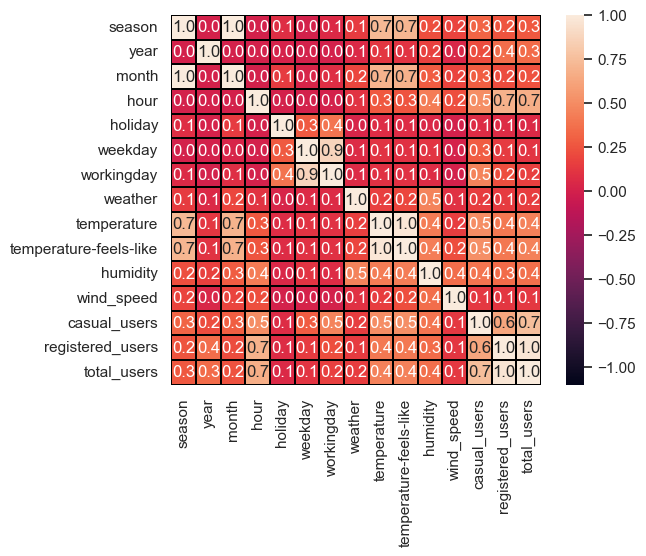

In [116]:
correlationMatrix = trainingDF.phik_matrix()
createHeatmap(correlationMatrix)

The heatmap above shows a PhiK correlation for all features and targets and provides a compact way of viewing the correlations but it harder to view. The ones prior to this are easier to view.

In [130]:

# TODO: Learn and do cross validation
scores = cross_val_score(linear_model.Lasso(), X_validation, y_validation, cv=10)
print(scores)

[ 0.00364234 -0.00879384 -0.01243585 -0.02571964 -0.02119295 -0.02030707
 -0.00519665 -0.00767841 -0.01093385 -0.03079114]


##End of Answer 2##

# Task 3: Using a forward selection approach, build a regression model that offers the best performance

##Start of Answer 3##

##End of Answer 3##

# Task 4: Which of the 3 target columns is easiest to predict accurately?

##Start of Answer 4##

##End of Answer 4##

# Task 5: Using this "preferred target", derive a new target whose values are the grouped label.

##Start of Answer 5##

##End of Answer 5##

# Task 6: Use _two_ classification procedures to predict these demand quartiles.

##Start of Answer 6

##End of Answer 6##

# Task 7: Does regression or classification provide the best classification accuracy on the test set? Why?

##Start of Answer 7

##End of Answer 7##